In [1]:
'''
Tom Egg
October 2, 2023
File to attempt analysis of tripeptoid enhanced sampling
'''

'\nTom Egg\nOctober 2, 2023\nFile to attempt analysis of tripeptoid enhanced sampling\n'

In [56]:
# Import libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv

# Free Energy Surfaces

In [67]:
# COLVAR
file_path = '/scratch/tje3676/openmm-test/COLVAR'

# Attempt to load
chunk_size = 50000
chunks = pd.read_csv(file_path, chunksize=chunk_size, delimiter='\t')

## $\psi_1$ vs $\phi_1$

In [41]:
# Histogram variables
hist = np.zeros((20, 20))
x_edge = None
y_edge = None

# Iterator
for chunk in chunks:

    # Chunk histogram
    chunk_hist, x_edges, y_edges = np.histogram2d(chunk['s_phi_1'], chunk['s_psi_1'], bins=[20, 20])

    # Add to total histogram
    hist += chunk_hist

In [42]:
# Transform to free energy:
beta = 1 / (8.314472 ** -3 * 3000)
def distribution_to_FE(hist):

    # Apply transformation
    hist = -(beta ** -1) * np.log(hist)
    return hist / 4.214

# Convert histogram to FE histogram
hist = distribution_to_FE(hist)

# Shift histogram
min_value = np.min(hist)
hist = hist - min_value

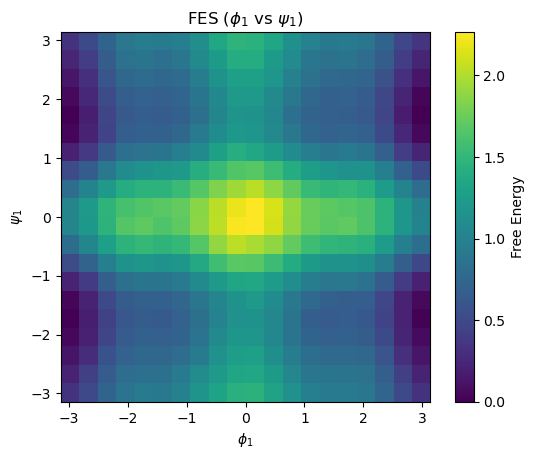

In [43]:
# Create a heatmap or 2D histogram plot
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_1$')
plt.ylabel('$\psi_1$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()

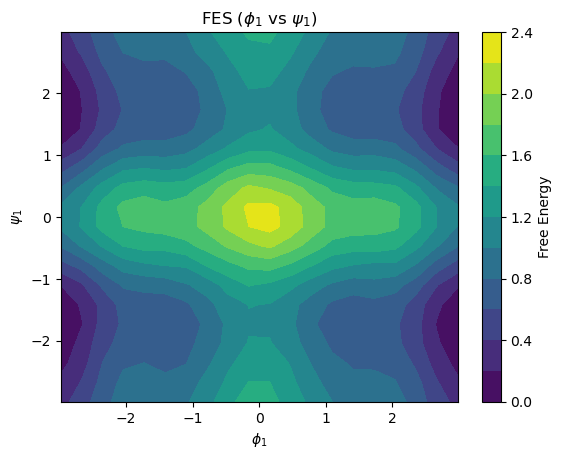

In [44]:
# Work with centers
x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

# Create a heatmap or 2D histogram plot
plt.contourf(x_centers, y_centers, hist, levels=12, cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_1$')
plt.ylabel('$\psi_1$')
plt.title('FES ($\phi_1$ vs $\psi_1$)')
plt.show()

## $\omega_1$ vs $\phi_1$

In [63]:
# Histogram variables
hist = np.zeros((20, 20))
x_edge = None
y_edge = None

# Iterator
for chunk in chunks:

    # Chunk histogram
    chunk_hist, x_edges, y_edges = np.histogram2d(chunk['s_phi_1'], chunk['s_omega_1'], bins=[20, 20])

    # Add to total histogram
    hist += chunk_hist

In [64]:
# Convert histogram to FE histogram
hist = distribution_to_FE(hist)

# Shift histogram
min_value = np.min(hist)
hist = hist - min_value

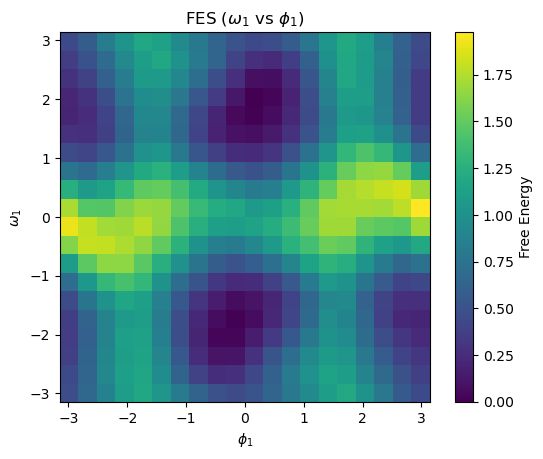

In [65]:
# Create a heatmap or 2D histogram plot
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_1$')
plt.ylabel('$\omega_1$')
plt.title('FES ($\omega_1$ vs $\phi_1$)')
plt.show()

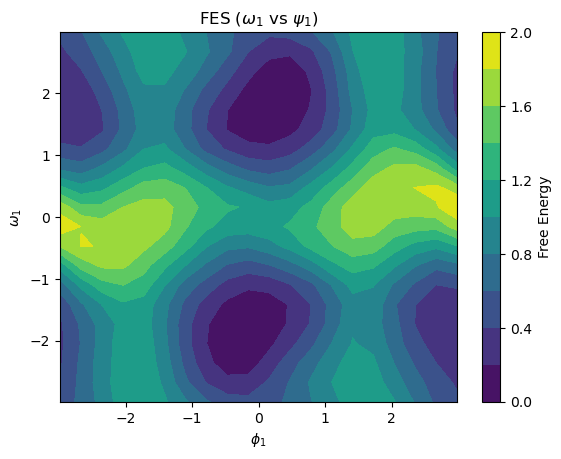

In [66]:
# Work with centers
x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

# Create a heatmap or 2D histogram plot
plt.contourf(x_centers, y_centers, hist, levels=12, cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_1$')
plt.ylabel('$\omega_1$')
plt.title('FES ($\omega_1$ vs $\psi_1$)')
plt.show()

## $\omega_1$ vs $\phi_2$

In [68]:
# Histogram variables
hist = np.zeros((20, 20))
x_edge = None
y_edge = None

# Iterator
for chunk in chunks:

    # Chunk histogram
    chunk_hist, x_edges, y_edges = np.histogram2d(chunk['s_phi_2'], chunk['s_omega_1'], bins=[20, 20])

    # Add to total histogram
    hist += chunk_hist

In [69]:
# Convert histogram to FE histogram
hist = distribution_to_FE(hist)

# Shift histogram
min_value = np.min(hist)
hist = hist - min_value

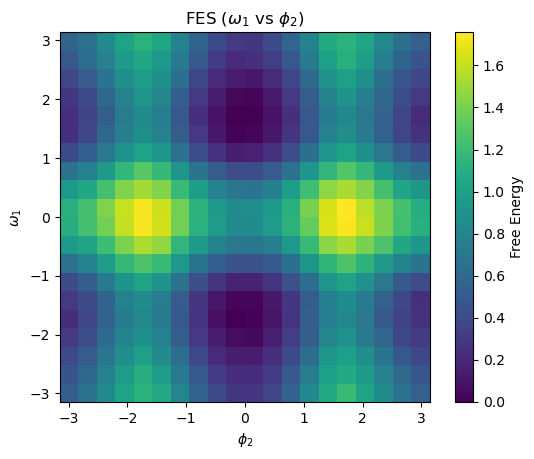

In [70]:
# Create a heatmap or 2D histogram plot
plt.imshow(hist, extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], origin='lower', cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_2$')
plt.ylabel('$\omega_1$')
plt.title('FES ($\omega_1$ vs $\phi_2$)')
plt.show()

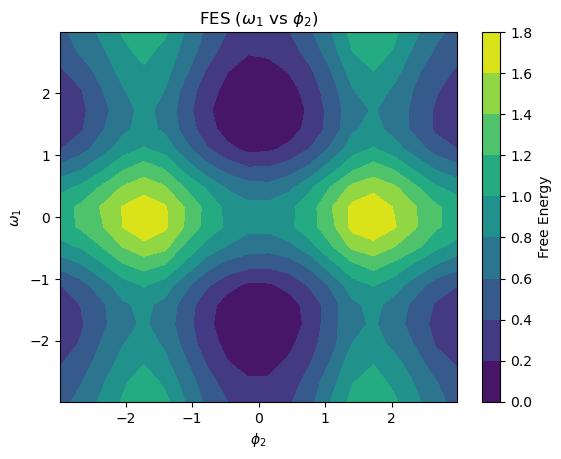

In [72]:
# Work with centers
x_centers = (x_edges[1:] + x_edges[:-1]) / 2
y_centers = (y_edges[1:] + y_edges[:-1]) / 2

# Create a heatmap or 2D histogram plot
plt.contourf(x_centers, y_centers, hist, levels=8, cmap='viridis')
plt.colorbar(label='Free Energy')
plt.xlabel('$\phi_2$')
plt.ylabel('$\omega_1$')
plt.title('FES ($\omega_1$ vs $\phi_2$)')
plt.show()

In [148]:
# Iterator
for chunk in chunks:
    print(chunk.columns)
    ldldl

Index(['#"Step"', 's_phi_1', 'phi1', 's_phi_2', 'phi2', 's_psi_1', 'psi1',
       's_psi_2', 'psi2', 's_omega_1', 'omega3', 'Speed (ns/day)'],
      dtype='object')


NameError: name 'ldldl' is not defined